# Ensamble de matrices

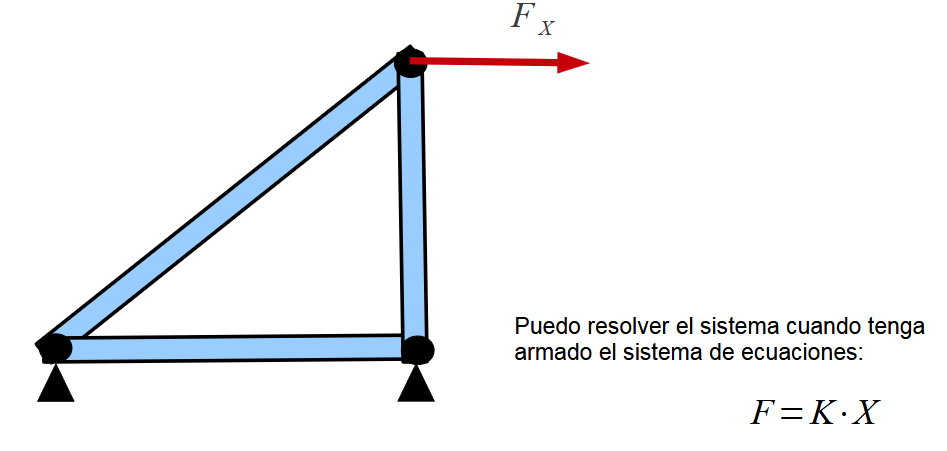

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
# Definicion de la matriz de nodos
# Cada fila de la matriz representa cada nodo del sistema, en las columnas se ponen las coordenadas de cada nodo.

L = 1       # [m]
A = 1e-4    # [m2]
E = 300e9   # [PA]

#   Para este caso el sistema esta definido por 3 nodos:
#............... MATRIZ DE NODOS .............................................
MN = np.array([[0, 0],
               [L, 0],
               [L, L]])

#   Se define la variable Grados de Libertar por Nodo (glxn)

glxn = 2    # Se tienen dos grados de libertad por cada nodo en el sistema

#.............................................................................

#.............. MATRIZ DE CONECTIVIDAD .......................................
#   Se tiene una fila por caa elemento que conforma el sistema y para cada elemento se completara con la lista de nodos
#   que lo conforma.

MC = np.array([[0, 1],
               [1, 2],
               [2, 0]])

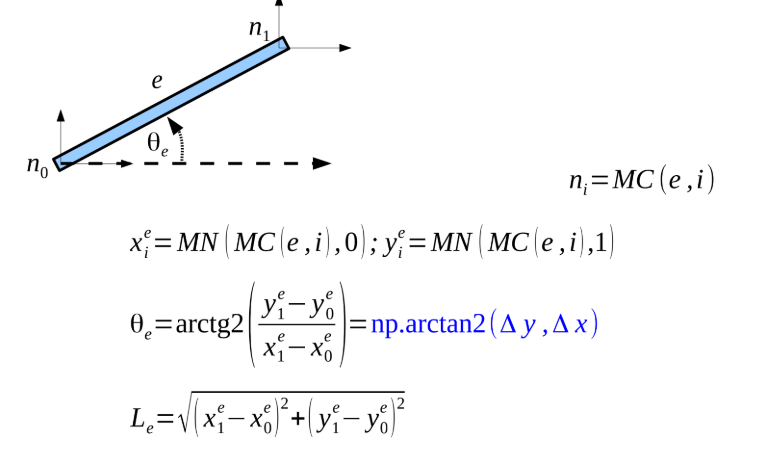

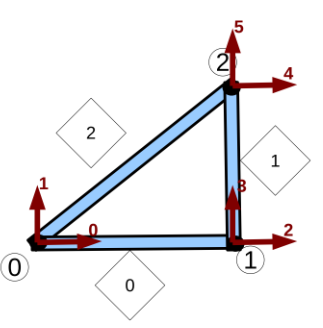

In [4]:
def MatrizDeRigidez(MC, MN, E, A, glxn):

	n,m = MC.shape		# n es la cantidad de elementos que va a tener mi sistema

	K = np.zeros((n*glxn,n*glxn))	#	Defino la matriz global de mi sistema

	for e in range(n):  # Recorro los elementos del sistema

		#	Calculo el angulo tita y la longitud para cada elemento

		tita_e = np.arctan2( MN[ MC[e,1] , 1 ] - MN[ MC[e,0] , 1 ] , MN[ MC[e,1] , 0 ] - MN[ MC[e,0] , 0 ])

		L_e = np.sqrt( (MN[ MC[e,1] , 0 ] - MN[ MC[e,0] , 0])**2 + (MN[ MC[e,1] , 1 ] - MN[ MC[e,0] , 1 ])**2 )

		#	Calculo la constate k que acompaña a cada matriz para cada elemento 
		
		k_e = ( E * A ) / L_e

		#	Se calcula la matriz de rotacion de cada elemento

		c = np.cos(tita_e)
		s = np.sin(tita_e)

		K_rot = k_e * np.array([[ c*c , c*s , -c*c , -c*s ],
						  		[ c*s , s*s , -c*s , -s*s ],
								[ -c*c , -c*s , c*c , c*s ],
								[ -c*s , -s*s , c*s , s*s ]])
		
		#	Son los nodos correspondiente al elemento del bucle

		ni = MC[e,0]
		nj = MC[e,1]

		indices = np.array([ ni * glxn , (ni + 1) * glxn -1 , nj * glxn , (nj + 1) * glxn - 1])
		
		#	Esta funcion es para crear una malla de indices.

		K[np.ix_(indices,indices)] += K_rot

		#print(K)
		#print(np.round(K_rot, 3))
		#print(np.round(K, 3))

	#print(K)
	return K

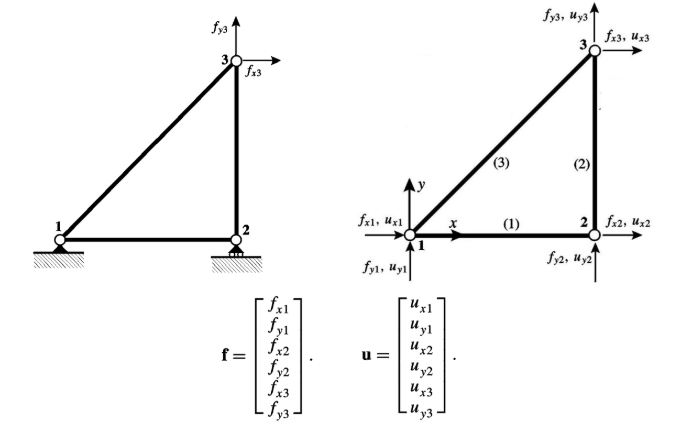

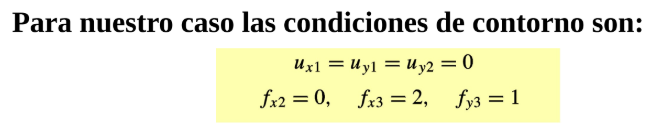

In [5]:
# A = np.array([
#    [ 20,  10, -10,   0, -10, -10],
#    [ 10,  10,   0,   0, -10, -10],
#    [-10,   0,  10,   0,   0,   0],
#    [  0,   0,   0,   5,   0,  -5],
#    [-10, -10,  0,   0,  10,  10],
#    [-10, -10,  0,  -5,  10,  15]])     # Esta es la matriz de prueba del apunte.

In [6]:
#   Para el problema defino la matriz de condiciones de contorno. 

#   La primera columna me indica el tipo de dato que conozco
#       Si es 0 se conoce la fuerza
#       Si es 1 se conoce el desplazamiento

b = np.array([[ 1 , 0 ],        # Para el nodo 0 en x
              [ 1 , 0 ],        # Para el nodo 0 en y
              [ 0 , 0 ],        # Para el nodo 1 en x
              [ 1 , 0 ],        # Para el nodo 1 en y
              [ 0 , 2 ],        # Para el nodo 2 en x
              [ 0 , 1 ]])       # Para el nodo 2 en y

In [ ]:
def ResolverSistemaMixto (A,b):
    #   Se define el vecctor de las fuerzas y los desplzamientos 

    n, m = np.shape(b)

    F = np.zeros([n,1])
    U = np.zeros([n,1])

    aux = b[:, 0] == 0  # Donde se conoce el valor de la fuerza
    aux2 = b[:, 0] == 1  # Donde se conoce el valor del desplazamiento

    I = np.arange(n) # Se define un vector de indices

    #print(aux)
    #print(aux2)

    f_indices = I[aux]   # Índices conocidos de fuerza
    #u_indices = I[aux2]  # Índices conocidos de dezplazamiento

    #   Esto asigna los valores que ya conozco a los vectores de Fuerza y Desplazamiento que quiero de mi problema

    F[aux] = b[aux,1].reshape(-1, 1) 
    U[aux2] = b[aux2,1].reshape(-1, 1)

    #print(F)
    #print(U)

    #   Construyo la matriz reducida

    A_red_f = A[np.ix_(f_indices,f_indices)]
    #A_red_u = A[np.ix_(u_indices,u_indices)]

    f_aux = F[f_indices]
    #u_aux = U[u_indices]

    #   Resuelvo el sistema de ecuaciones reducido

    u_sol = np.linalg.solve( A_red_f , f_aux )
    #f_sol = np.linalg.solve( np.linalg.inv(A_red_u) , u_aux )  # Para que esto funcione tengo que que invertir la matriz A_red_u

    #   Asigno los valores calculados a mi vector de Desplazamientos con CC

    U[f_indices] = u_sol
    #F[u_indices] = f_sol

    F = np.dot(A,U)     # Se multiplican las matries para encontrar el vector de Fuerzas ... 

    return U, F


In [ ]:
K = MatrizDeRigidez(MC, MN, E, A, glxn)

U,F = ResolverSistemaMixto (K,b)

np.set_printoptions(suppress=True, precision=10)        # Para eliminar los exponenciales

print(np.round(U,10))
print(np.round(F,10))

[[ 0.          ]
 [ 0.          ]
 [-0.          ]
 [ 0.          ]
 [ 0.0000002219]
 [-0.0000000333]]
[[-2.]
 [-2.]
 [ 0.]
 [ 1.]
 [ 2.]
 [ 1.]]
